In [29]:
import pandas as pd
import numpy as np 
import selenium
import requests
from bs4 import BeautifulSoup
import re
from IPython.display import Image
from selenium.webdriver import Chrome 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime as date
import mysql.connector
from pandas.io import sql
import datetime as dt
import pymysql
import sqlite3
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict,cross_val_score,GridSearchCV,RepeatedKFold
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import cdist


**Web Scrappying**

Comenzamos por la extracción de los datos. Utilizaremos selenium para acceder a la pagina web: https://datosclima.es/Aemethistorico/Precipisolstad.php y beautifulSoap para la extraccion de los datos. 

El web scrapping se estructura en los siguientes pasos:
* Conexion con Chrome driver
* acceder a la url donde estan los datos
* Utilizar BeautifulSoup para navegar por el codigo html y extraer los datos elegidos
* Guardar los datos en un dataframe


In [446]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [C:\Users\adria\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


In [447]:
url = 'https://datosclima.es/Aemet2013/Precipitastad2013.php'

In [448]:
driver.get(url)

Con las siguientes lineas de codigo accedemos a la url donde se encuentra las tablas con los datos

In [449]:
link= driver.find_element_by_link_text('Precipitacion')
link.click()

In [450]:
prov = driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/select[1]')

In [451]:
prov.send_keys('Barcelona')



In [452]:
estacio=driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/select[2]')
estacio.send_keys('Barcelona')

In [453]:
#Fecha inicial
driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/div/table/tbody/tr/td[2]/input[1]').send_keys('01')
driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/div/table/tbody/tr/td[2]/input[2]').send_keys('01')
driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/div/table/tbody/tr/td[2]/input[3]').send_keys('2013')

In [454]:
#fecha final
driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/div/table/tbody/tr/td[5]/input[1]').send_keys('29')
driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/div/table/tbody/tr/td[5]/input[2]').send_keys('11')
driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/div/table/tbody/tr/td[5]/input[3]').send_keys('2021')
driver.find_element_by_xpath('//*[@id="col2"]/div[1]/div/form/input[5]').click()

Parseamos  el el codigo html de la pagina a  un una instancia de beautifulsoup y navegamos por el codigo htm y almacenamos los datos en dos listas: 
* fecha  
* val 

In [456]:
data = BeautifulSoup(driver.page_source,'html.parser')

In [457]:
data = BeautifulSoup(driver.page_source,'html.parser')
table = data.find('div',attrs={'class':'feature'})
fecha = []
val = []
for tables in table.findAll("table"):
    for table in tables.findAll('tr'):
        for t in table.findAll('tr'):
            row = t.get_text()
            if not('Precipitación: l/m2') or not('FECHA') in row:
                
                if isinstance(row,str) and '-'in row:
                    
                    fecha.append(row[:10])
                    val.append(row[10:])
           
            
 

In [458]:
df=pd.DataFrame(columns={'fecha','lm'})

In [459]:
df['fecha']=fecha
df['lm']=val
print(df)

           fecha   lm
0     07-05-2013    0
1     08-05-2013    0
2     09-05-2013    0
3     10-05-2013  0.7
4     11-05-2013  0.3
...          ...  ...
3055  27-10-2021    0
3056  28-10-2021    0
3057  29-10-2021  6.6
3058  30-10-2021   13
3059  31-10-2021  0.2

[3060 rows x 2 columns]


Paso los datos extraidos a un dataframe 

In [443]:
df.to_csv('precipitaciones_2013-2021.csv')

***SQL***

En este apartado  subimos los datos a una base de datos en mysql

In [3]:
df=pd.read_csv('precipitaciones_2013-2021.csv')

In [4]:
df2  = pd.read_csv('precipitaciones_1786.csv')

In [7]:
mydb = pymysql.connect(
    host = 'localhost',
    user = 'root',
    password = 'Adria1994',
    database = 'precipitaciones'
    )
mycursor = mydb.cursor()

In [20]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [10]:
mycursor.execute('show tables')
for x in mycursor: 
    print(x)

('precipitaciones_13_21',)
('precipitaciones_1786',)


In [8]:
hostname='localhost'
dbname='precipitaciones'
uname= 'root'
pwd='Adria1994'

engine = create_engine("mysql+pymysql://{user}:{password}@{server}/{database}".format(user=uname
                                                                                      , password=pwd
                                                                                      , server=hostname
                                                                                    , database=dbname))

In [23]:
df.to_sql(con=engine,name='precipitaciones_2013_2021',if_exists='replace')



In [24]:
df2.to_sql(con=engine,name='precipitaciones_1786',if_exists='replace')

**Analisis Descriptivo**

Una vez tenemos todos los datos, empezamos con el analisis descriptivo de los datos

In [9]:
df = pd.read_sql('SELECT * FROM precipitaciones_2013_2021',con=engine)

In [10]:
df2 = pd.read_sql('SELECT * FROM precipitaciones_1786 ', con=engine)

In [11]:

df2.drop(['index'],axis=1,inplace=True)

Para juntar los dos dataframes  filtramos el dataframe de temperaturas a temperaturas a partir del año 1786 para que cuadre con el dataframe de las  precipitaciones

In [12]:
df_temp = pd.read_csv('temperatures_1780.csv')

df_temp = df_temp.loc[df_temp['Any']>=1786]

df_ml = pd.merge(df2,df_temp,on='Any')


Una vez  tenemos los dos datasets junto, analizamos si tiene valores nulos y una breve descripcion del dataframe

In [13]:
df_ml.isna().sum()

Any                      0
Precip_Acum_Gener        0
Precip_Acum_Febrer       0
Precip_Acum_Marc         0
Precip_Acum_Abril        0
Precip_Acum_Maig         0
Precip_Acum_Juny         0
Precip_Acum_Juliol       0
Precip_Acum_Agost        0
Precip_Acum_Setembre     0
Precip_Acum_Octubre      0
Precip_Acum_Novembre     0
Precip_Acum_Desembre     0
Temp_Mitjana_Gener       0
Temp_Mitjana_Febrer      0
Temp_Mitjana_Marc        0
Temp_Mitjana_Abril       0
Temp_Mitjana_Maig        0
Temp_Mitjana_Juny        0
Temp_Mitjana_Juliol      0
Temp_Mitjana_Agost       0
Temp_Mitjana_Setembre    0
Temp_Mitjana_Octubre     0
Temp_Mitjana_Novembre    0
Temp_Mitjana_Desembre    0
dtype: int64

In [14]:
df_ml.describe()

,Any,Precip_Acum_Gener,Precip_Acum_Febrer,Precip_Acum_Marc,Precip_Acum_Abril,Precip_Acum_Maig,Precip_Acum_Juny,Precip_Acum_Juliol,Precip_Acum_Agost,Precip_Acum_Setembre,...,Temp_Mitjana_Marc,Temp_Mitjana_Abril,Temp_Mitjana_Maig,Temp_Mitjana_Juny,Temp_Mitjana_Juliol,Temp_Mitjana_Agost,Temp_Mitjana_Setembre,Temp_Mitjana_Octubre,Temp_Mitjana_Novembre,Temp_Mitjana_Desembre
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,...,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,1903.000000,38.305106,34.840000,48.945957,53.826383,54.027234,37.457021,26.325532,39.323404,79.011915,...,10.299149,12.478723,15.901702,19.596170,22.499149,22.636170,19.809362,15.828511,11.212766,8.335319
std,67.982841,38.661352,36.221712,38.155859,37.083888,40.541271,32.398380,28.123101,34.873890,55.904511,...,1.410370,1.243605,1.472772,1.607045,1.556349,1.379989,1.371535,1.403078,1.377446,1.429627
min,1786.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,...,6.100000,9.400000,11.500000,15.700000,18.400000,18.800000,16.000000,11.000000,7.300000,4.400000
25%,1844.500000,11.700000,10.750000,21.650000,25.600000,26.300000,13.550000,4.850000,12.200000,36.800000,...,9.500000,11.550000,14.900000,18.500000,21.400000,21.650000,18.800000,14.900000,10.350000,7.300000
50%,1903.000000,28.300000,25.500000,39.000000,45.800000,45.000000,32.500000,16.900000,30.400000,68.400000,...,10.200000,12.500000,15.800000,19.600000,22.400000,22.400000,19.800000,15.800000,11.300000,8.400000
75%,1961.500000,52.950000,46.850000,69.500000,76.800000,72.750000,51.600000,38.950000,58.650000,104.150000,...,11.100000,13.300000,16.850000,20.650000,23.450000,23.500000,20.800000,16.700000,12.100000,9.300000
max,2020.000000,262.400000,275.100000,188.500000,258.700000,235.100000,183.300000,163.200000,196.200000,338.500000,...,14.800000,15.900000,19.400000,25.600000,27.100000,28.500000,23.900000,19.600000,14.700000,12.600000


Creamos una nueva columna con la suma de las medias por año para ver la tendencia media durante el transcurso de los años

In [15]:
df_ml['mitja_total_any']=df_ml.iloc[:,2:14].sum(axis=1)

Text(0.5, 0, 'anys')

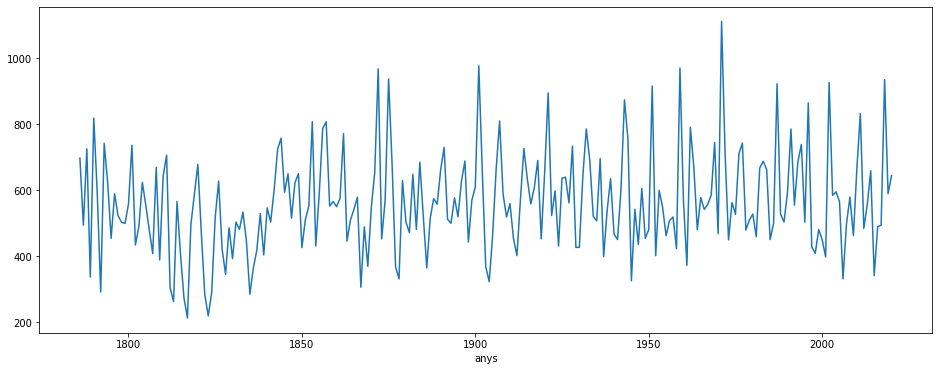

In [16]:
plt.figure(figsize=(16,6))
plt.plot(df_ml['Any'],df_ml['mitja_total_any'])
plt.xlabel('anys')

Vemos que la suma de las medias  tiene una tendencia lineal sin apenas incremento durante los años. Al ser un proyecto de predicion  con un dataframe  tipo time series deberiamos abordar  el proyecto de de forma distinta debido que  en este caso el tiempo tiene un papel importante , no obstante por la falta de tiempo  abordaremos  el proyecto de forma usual  para mostrar la metodologia e implantacion de modelos de machine learning aunque no  refleje buenos resultados

cambiamos todos los nombres de las variables a uno mas corto por comodidad

In [17]:


names = {'Any':'Any',
             'mitja_total_any':'mitja_any',
             'Precip_Acum_Gener':'p_gener',
             'Precip_Acum_Febrer':'p_febrer',
             'Precip_Acum_Marc':'p_marc',
             'Precip_Acum_Abril':'p_abril',
             'Precip_Acum_Maig':'p_maig',
             'Precip_Acum_Juny':'p_juny',
             'Precip_Acum_Juliol':'p_juliol',
             'Precip_Acum_Agost':'p_agost',
             'Precip_Acum_Setembre':'p_setembre',
             'Precip_Acum_Octubre':'p_octubre', 
             'Precip_Acum_Novembre':'p_novembre',
             'Precip_Acum_Desembre':'p_desembre',
             'Temp_Mitjana_Gener':'t_gener', 
             'Temp_Mitjana_Febrer':'t_febrer', 
             'Temp_Mitjana_Marc':'t_marc',
             'Temp_Mitjana_Abril':'t_abril', 
             'Temp_Mitjana_Maig':'t_maig',
             'Temp_Mitjana_Juny':'t_juny',
             'Temp_Mitjana_Juliol':'t_juliol', 
             'Temp_Mitjana_Agost':'t_agost',
             'Temp_Mitjana_Setembre':'t_setembre', 
             'Temp_Mitjana_Octubre':'t_octubre',
             'Temp_Mitjana_Novembre':'t_novembre', 
             'Temp_Mitjana_Desembre':'t_desembre', 
            }
df_ml =df_ml.rename(columns=names)

Reorganizamos las columnas de forma  que estaran agrupadas temperatura con precipitacion

In [18]:
cols = ['Any', 'mitja_any','t_gener','p_gener', 't_febrer', 'p_febrer','t_marc', 'p_marc', 't_abril', 'p_abril',
       't_maig','p_maig','t_juny', 'p_juny',  't_juliol','p_juliol','t_agost',  'p_agost', 't_setembre', 'p_setembre',
        't_octubre','p_octubre','t_novembre','p_novembre',  't_desembre','p_desembre']

In [19]:
df_ml =df_ml[cols]

In [20]:
df_ml

,Any,mitja_any,t_gener,p_gener,t_febrer,p_febrer,t_marc,p_marc,t_abril,p_abril,...,t_agost,p_agost,t_setembre,p_setembre,t_octubre,p_octubre,t_novembre,p_novembre,t_desembre,p_desembre
0,1786,697.2,7.8,32.8,8.3,28.4,9.9,84.4,12.8,42.3,...,21.1,52.1,19.5,62.0,15.5,57.0,9.2,195.8,8.3,114.1
1,1787,494.1,5.4,136.4,7.8,27.4,11.3,44.6,12.1,76.9,...,21.8,14.9,19.4,205.8,15.5,12.4,9.3,42.2,10.8,0.0
2,1788,725.3,6.4,9.9,10.1,14.9,10.4,32.2,12.5,12.4,...,23.0,29.8,19.1,123.9,15.5,163.6,10.5,106.6,5.4,22.3
3,1789,337.0,6.9,12.4,9.3,12.4,8.7,23.6,13.3,9.9,...,21.9,69.4,20.0,18.7,14.7,52.1,7.8,18.7,7.3,76.9
4,1790,818.5,7.4,44.6,9.5,1.2,10.4,188.5,12.3,74.4,...,23.1,32.3,19.3,71.9,17.1,205.8,11.7,72.0,7.9,14.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2016,489.8,10.7,1.1,11.3,39.9,11.1,44.2,13.6,68.1,...,24.5,17.6,22.3,95.7,17.1,75.8,12.7,38.5,11.5,34.3
231,2017,494.3,7.9,32.0,11.4,31.2,13.3,136.4,14.2,48.1,...,24.5,17.4,19.5,53.3,18.6,128.2,12.5,15.2,8.5,3.1
232,2018,934.9,10.5,63.6,6.7,104.6,10.8,112.5,14.7,83.0,...,25.8,36.5,22.5,44.4,17.0,201.9,12.4,201.8,11.1,4.8
233,2019,589.7,8.1,18.2,11.9,4.6,13.5,0.3,13.4,36.2,...,25.1,23.1,21.8,71.5,18.5,83.2,11.9,39.4,11.2,119.2


Realizamos un grafico con el historico de las medias de los meses durante todo el periodo donde podemos observar  outliers.
En este grafico de puede observar  la ciclicidad  de los datos

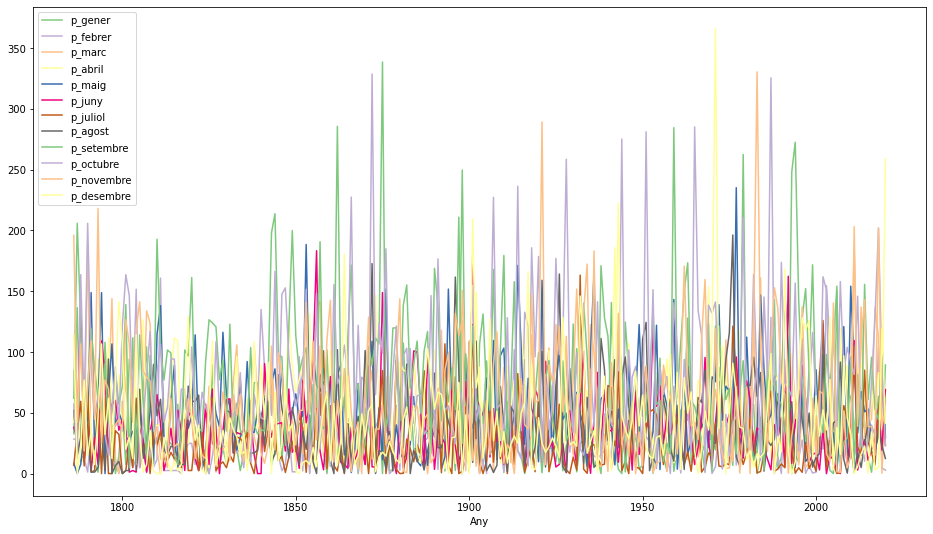

In [174]:


temp = ['p_gener', 'p_febrer', 'p_marc','p_abril','p_maig','p_juny','p_juliol','p_agost','p_setembre','p_octubre','p_novembre','p_desembre']
df_ml.plot(x="Any", y=temp,figsize=(16,9))

plt.show()

Realizamos un barplot con la suma de medias por decadas , vemos que tiene practicamente una distribucion uniforme

In [22]:
dec=df_ml.groupby((df_ml.Any //10)*10)['mitja_any'].sum().reset_index(name='total')

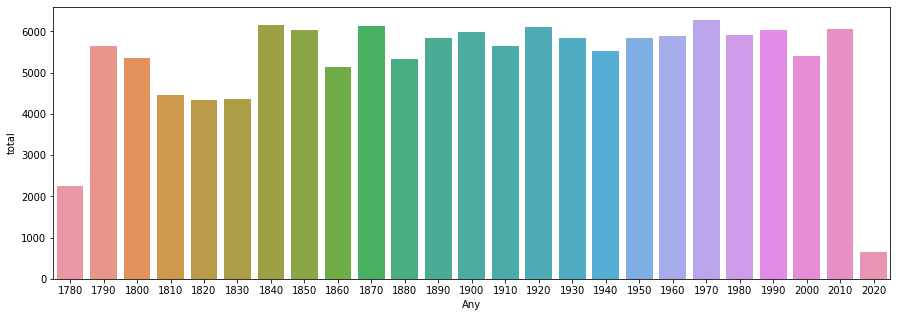

In [23]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=dec['Any'], y=dec['total'])


En el siguiente  grafico observamos las distribuciones por  meses. Vemos que  setiembre tiene tiene mucha mas densidad  respecto las otras, indicando outliers  a partir de 200 lm/m^2

<Figure size 1080x360 with 0 Axes>

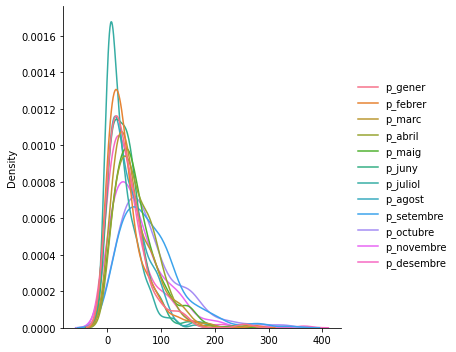

In [23]:
plt.figure(figsize=(15,5))
p_cols =['p_gener', 'p_febrer', 'p_marc', 'p_abril','p_maig', 'p_juny', 'p_juliol', 'p_agost', 'p_setembre', 'p_octubre','p_novembre', 'p_desembre']
sns.set_palette("Accent")
sns.displot(df_ml.loc[:,p_cols],kind="kde" )



Para  ver con mas detalle posibles outlier  realizamos un boxplot con los diferentrs meses


<AxesSubplot:>

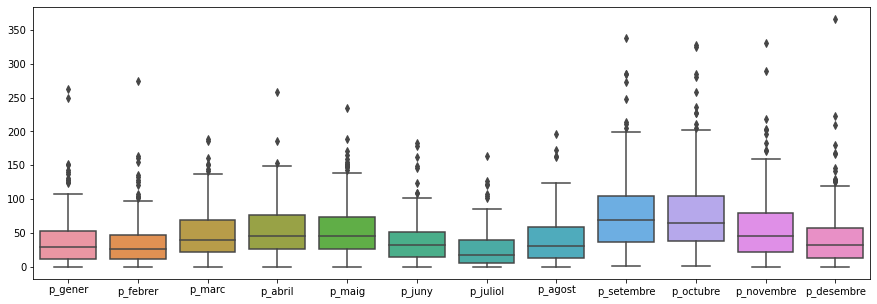

In [25]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_ml[p_cols])

***Tractamiento de outliers***

In [24]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    q1,q3= np.percentile(datacolumn , [25,75])
    iqr = q3 - q1
    lower_range = q1 - (1.5 * iqr)
    upper_range = q3 + (1.5 * iqr)
    return lower_range,upper_range

In [25]:
for x in df_ml.loc[:,p_cols]:
    lowerbound,upperbound = outlier_treatment(df_ml[x])
    df_ml.drop(df_ml[ (df_ml[x] > upperbound) | (df_ml[x]< lowerbound) ].index , inplace=True)
    

<Figure size 1080x360 with 0 Axes>

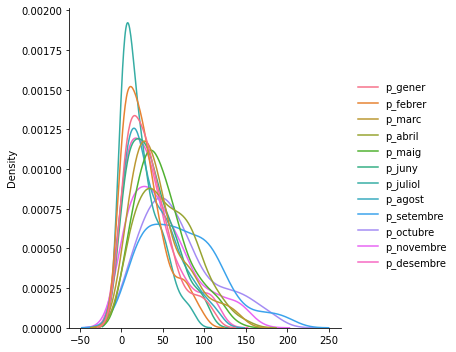

In [181]:
plt.figure(figsize=(15,5))
sns.set_palette("Accent")
sns.displot(df_ml.loc[:,p_cols],kind="kde" )

<AxesSubplot:>

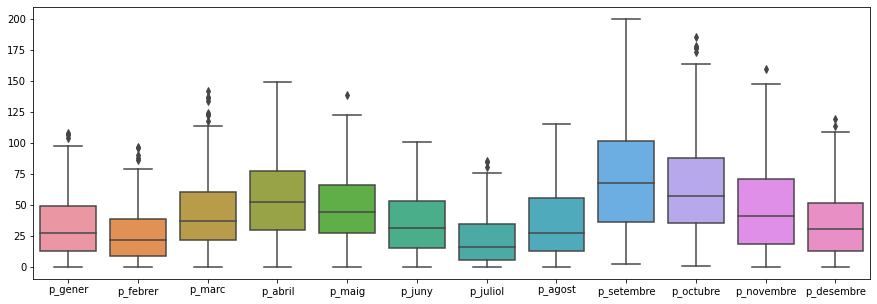

In [182]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_ml.loc[:,p_cols])

In [29]:
corr_matrix =df_ml.corr()

<AxesSubplot:>

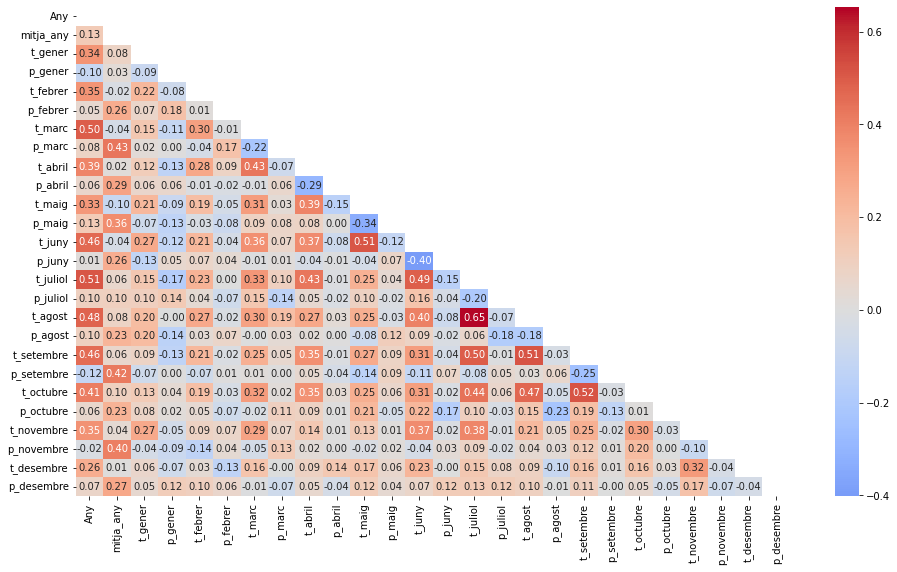

In [183]:
plt.figure(figsize=(16,9))
matrix = np.triu(corr_matrix)


sns.heatmap(corr_matrix, center=0, annot=True, 
                fmt='.2f', cmap='coolwarm',mask=matrix)

**Implementacion de Machine learning supervisado**

Trataremos de realizar un modelo regresivo para predecir las medias de lluvias de diciembre.
Para empezar realizamos una regresion sin tratar mucho los datos para ver las primeras metricas de los modelos suport vector machine , random forest y lasso


In [188]:
X = df_ml.drop(['p_desembre','mitja_any','Any'],axis=1)
y = df_ml['p_desembre']

In [189]:
X.keys()

Index(['t_gener', 'p_gener', 't_febrer', 'p_febrer', 't_marc', 'p_marc',
       't_abril', 'p_abril', 't_maig', 'p_maig', 't_juny', 'p_juny',
       't_juliol', 'p_juliol', 't_agost', 'p_agost', 't_setembre',
       'p_setembre', 't_octubre', 'p_octubre', 't_novembre', 'p_novembre',
       't_desembre'],
      dtype='object')

In [190]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [191]:
svm = SVR(kernel = 'linear')

In [192]:
svm.fit(X_train,y_train)

SVR(kernel='linear')

In [193]:
y_pred = svm.predict(X_test)

In [198]:
print('Metricas SVM')
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE:',mean_absolute_error(y_test,y_pred))
print('r2 score:',r2_score(y_test,y_pred))

Metricas SVM
RMSE: 32.78519757072287
MAE: 22.96855993168974
r2 score: 0.0016962056109163237


In [195]:
def PrintActualPredicted(act,pred):
    df_print = pd.DataFrame({'Actual':act,'Predicción':pred})
    return(df_print)

In [196]:
PrintActualPredicted(y_test,y_pred).head()

,Actual,Predicción
93,11.4,0.801913
124,34.5,19.110123
116,70.4,3.136592
182,51.5,20.275842
22,35.8,33.087376


In [200]:
print('Metricas Lasso')
print('RMSE:',np.sqrt(mean_squared_error(y,lasso_pred)))
print('MAE:',mean_absolute_error(y,lasso_pred))
print('r2 score:',r2_score(y,lasso_pred))


PrintActualPredicted(y_test,y_pred).head()

Metricas Lasso
RMSE: 31.455231407549785
MAE: 24.928301332577906
r2 score: -0.10329875020550916


,Actual,Predicción
93,11.4,0.801913
124,34.5,19.110123
116,70.4,3.136592
182,51.5,20.275842
22,35.8,33.087376


In [201]:
rf = RandomForestRegressor()

In [202]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [203]:
rf_pred =rf.predict(X_test)

In [205]:
print('Metricas Random Forest')
print('RMSE:',np.sqrt(mean_squared_error(y_test,rf_pred)))
print('MAE:',mean_absolute_error(y_test,rf_pred))
print('r2 score:',r2_score(y_test,rf_pred))

Metricas Random Forest
RMSE: 32.89593732456241
MAE: 25.20030769230769
r2 score: -0.0050591981851204615


A primera instancia vemos metricas muy bajas, se podria deber al tamaño reducido del dataframe y a que para predecir la lluvia se necesitan mas variables como la presion atmosferica

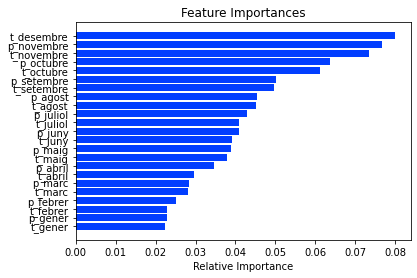

In [206]:
f =rf.feature_importances_
importances = f
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),X.keys())
plt.xlabel('Relative Importance')
plt.show()

**Standarizacion de los datos y seleccion de variables**


Para intentar mejorar el rendimiento de los modelos  estandarizaremos los datos y selecionaremos las variables las cuales han tenido mas peso en random forest

In [26]:
select_cols=['p_maig','p_setembre', 't_octubre', 'p_octubre', 't_novembre', 'p_novembre','t_desembre']

In [27]:
sc = StandardScaler()
X = df_ml[select_cols]
y = df_ml['p_desembre']

In [28]:
X =sc.fit_transform(X)

In [210]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [211]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf, X, y, 
                         cv=cv, n_jobs=-1)


In [212]:
print('mean scores:',np.mean(scores))

mean scores: -0.27395799919890224


In [213]:
svm = SVR(kernel = 'linear')

In [214]:
svm.fit(X_train,y_train)

SVR(kernel='linear')

In [215]:
y_pred = svm.predict(X_test)

In [216]:
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE:',mean_absolute_error(y_test,y_pred))
print('r2 score:',r2_score(y_test,y_pred))

RMSE: 34.09000742250809
MAE: 28.13224312662953
r2 score: -0.12351662668760666


In [217]:
rf = RandomForestRegressor()

In [218]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [219]:
rf_pred =rf.predict(X_test)

In [220]:
print('RMSE:',np.sqrt(mean_squared_error(y_test,rf_pred)))
print('MAE:',mean_absolute_error(y_test,rf_pred))
print('r2 score:',r2_score(y_test,rf_pred))

RMSE: 35.070681055073145
MAE: 30.594333333333317
r2 score: -0.18908722080802853


**Grid search**

In [221]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [222]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [223]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.2min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [224]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

In [227]:
best_grid = grid_search.best_estimator_

In [228]:
best_grid.fit(X_train,y_train)

RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=5,
                      min_samples_split=12)

In [229]:
rf_pred =best_grid.predict(X_test)

In [230]:
print('RMSE:',np.sqrt(mean_squared_error(y_test,rf_pred)))
print('MAE:',mean_absolute_error(y_test,rf_pred))
print('r2 score:',r2_score(y_test,rf_pred))

RMSE: 33.546117646293666
MAE: 28.38158719239851
r2 score: -0.08795227256040561


***Unsupervised model***

Realizaremos un modelo de machine learning no supervisado en el que trataremos de de estudiar los diferentes grupos realizados por el modelo

In [30]:
df_scaled = df_ml.copy()
df_scaled.keys()

Index(['Any', 'mitja_any', 't_gener', 'p_gener', 't_febrer', 'p_febrer',
       't_marc', 'p_marc', 't_abril', 'p_abril', 't_maig', 'p_maig', 't_juny',
       'p_juny', 't_juliol', 'p_juliol', 't_agost', 'p_agost', 't_setembre',
       'p_setembre', 't_octubre', 'p_octubre', 't_novembre', 'p_novembre',
       't_desembre', 'p_desembre'],
      dtype='object')

In [33]:
df_scaled.head()

,Any,mitja_any,t_gener,p_gener,t_febrer,p_febrer,t_marc,p_marc,t_abril,p_abril,...,t_agost,p_agost,t_setembre,p_setembre,t_octubre,p_octubre,t_novembre,p_novembre,t_desembre,p_desembre
3,-1.583382,-1.527820,-0.401089,-0.782758,0.424697,-0.624376,-1.010181,-0.648301,0.832990,-1.330493,...,-0.461410,1.128967,0.221594,-1.207930,-0.696012,-0.357882,-2.391301,-0.806480,-0.607322,1.367243
6,-1.538159,-1.938041,0.779185,-0.922457,0.172661,-0.728578,0.830456,-0.532571,1.397037,-1.437080,...,0.055101,-1.199649,-1.262123,0.296696,-0.011993,-0.471270,-0.238571,-0.138984,-0.071347,-0.950222
9,-1.492937,-0.462335,-0.794513,2.826752,-0.205393,-0.415971,-0.328464,-0.760985,0.349521,-0.667284,...,-0.166261,-1.155262,0.080288,0.376235,1.356046,-0.806901,-1.530209,0.687684,1.000602,-0.122079
10,-1.477862,0.761067,0.975898,0.391465,-0.457429,0.821954,-2.373616,0.441996,-0.133948,1.680592,...,-0.461410,1.975736,-0.343631,-0.688713,-0.285600,-1.201495,-1.314936,0.495137,-0.339334,0.869689
12,-1.447714,-0.018534,-0.269947,-1.250938,-0.016366,-0.728578,-0.192120,-0.989400,0.349521,-0.246857,...,0.866761,-1.022101,0.645513,0.239250,1.150840,0.447179,0.694279,-0.251945,0.799611,1.273743


Escalamos los datos para seguidamente realizar un pca

In [35]:
features = df_scaled
scaler = sc.fit(features.values)
df_scaled[features.columns] = scaler.transform(features.values)

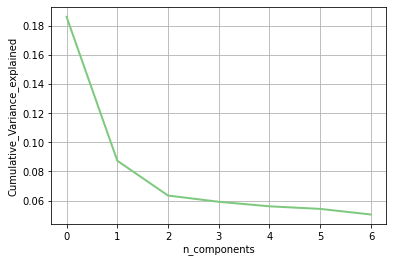

In [47]:
pca=PCA()  
pca.n_components=7
pca_data=pca.fit_transform(df_scaled)
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot PCA spectrum   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(percentage_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

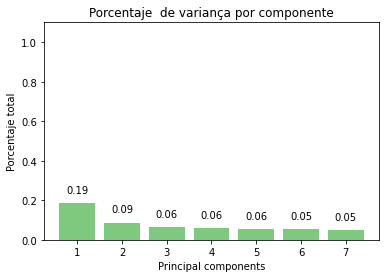

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_scaled.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje  de variança por componente')
ax.set_xlabel('Principal components')
ax.set_ylabel('Porcentaje total');

In [49]:
pca_data = pd.DataFrame(pca_data)
pca_data.rename(columns={0: 'principal component 1', 1: 'principal component 2',2:'principal component 3'}, inplace=True)

para encontrar el numero de cluster realizamos  dos tecnicas:
* Elbow Method
* KneeLocator

In [65]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    
    kmeanModel = KMeans(n_clusters=k).fit(df_scaled)
    kmeanModel.fit(df_scaled)
 
    distortions.append(sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / df_scaled.shape[0]
    mapping2[k] = kmeanModel.inertia_

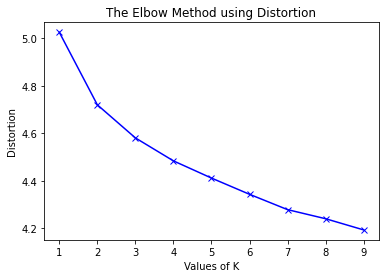

In [66]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [67]:
kl = KneeLocator(range(1, 10), inertias, curve="convex", direction="decreasing")
print('number of clusters',kl.elbow)

number of clusters 3


Realizamos el clustering con  n=3 i vemos los resultados

In [57]:
kmeans = KMeans(init='random',n_clusters = 3)
kmeans.fit(df_scaled)
KMeans(n_clusters=3)
pca_data['Clusters'] = kmeans.fit_predict(df_scaled)

In [58]:
pca_data

,principal component 1,principal component 2,principal component 3,3,4,5,6,Clusters
0,-1.512864,-2.548584,0.110370,-0.973292,0.102859,2.309188,0.141959,0
1,-0.358490,-2.757052,-0.380779,-1.012414,0.644556,1.059660,0.695467,0
2,-1.483428,-1.218260,-0.284841,3.665093,2.215553,0.523864,0.205051,0
3,-2.149454,1.575281,0.723253,-0.904652,-2.048942,0.393727,-0.652411,1
4,1.029694,-0.517138,-0.175740,0.834574,1.532583,-0.411777,0.230589,2
...,...,...,...,...,...,...,...,...
149,4.442518,1.649800,-2.019409,1.638491,0.587385,-0.793469,2.203206,2
150,5.077116,-2.141502,-0.856867,-1.485734,-0.653100,-1.108631,1.000750,2
151,4.830392,-0.178810,-0.069672,-0.372932,-0.734053,-1.050740,-0.364129,2
152,5.071264,-0.556741,1.497275,0.130118,-0.794715,0.553104,0.041158,2


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

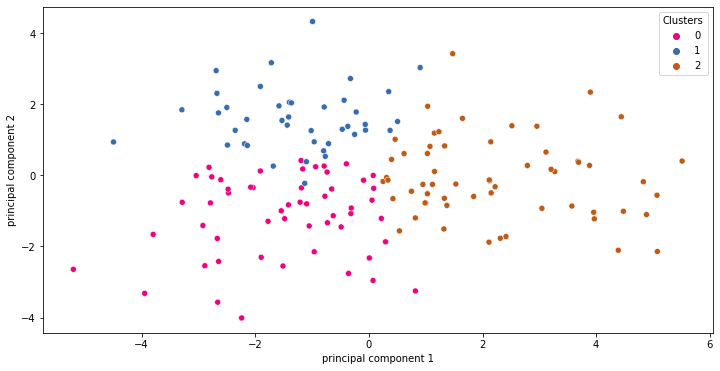

In [59]:
plt.figure(figsize=(12,6))
sns.set_color_codes('bright')
sns.scatterplot(data=pca_data, x='principal component 1', y='principal component 2', hue="Clusters",palette=["C5", "C4", "C6"])

El grafico nos muestra una separacions de los datos en tres grupos 


In [61]:
df_ml.loc[:,'clusters']=pca_data['Clusters']

In [65]:
df_ml.loc[df_ml.clusters==0].describe()

,Any,mitja_any,t_gener,p_gener,t_febrer,p_febrer,t_marc,p_marc,t_abril,p_abril,...,p_agost,t_setembre,p_setembre,t_octubre,p_octubre,t_novembre,p_novembre,t_desembre,p_desembre,clusters
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0
mean,1833.615385,466.174359,6.635897,35.587179,8.148718,24.284615,9.315385,37.512821,11.907692,49.335897,...,25.576923,19.192308,77.935897,15.192308,63.135897,10.861538,52.628205,7.933333,31.007692,0.0
std,26.976223,120.627994,1.340559,27.483920,1.419390,23.489825,1.291580,30.578141,1.137491,33.238575,...,21.109457,1.207517,38.421701,1.140033,34.021290,1.297693,39.701604,1.197439,29.682685,0.0
min,1798.000000,213.200000,3.400000,0.000000,5.000000,0.000000,6.100000,1.200000,9.500000,0.000000,...,0.000000,17.200000,4.900000,12.900000,4.900000,7.900000,0.000000,5.300000,0.000000,0.0
25%,1813.500000,413.250000,5.850000,16.100000,7.700000,6.200000,8.850000,12.400000,11.200000,23.200000,...,10.300000,18.350000,45.550000,14.450000,41.450000,10.050000,24.800000,6.900000,8.000000,0.0
50%,1825.000000,490.400000,6.700000,32.000000,8.300000,18.100000,9.500000,30.200000,11.600000,43.400000,...,18.600000,19.000000,84.200000,15.200000,55.800000,10.700000,40.300000,8.100000,27.400000,0.0
75%,1853.000000,552.500000,7.500000,50.850000,8.900000,34.700000,10.100000,49.450000,12.700000,68.450000,...,35.650000,20.400000,105.100000,15.950000,84.900000,11.800000,74.050000,8.650000,37.750000,0.0
max,1895.000000,678.700000,9.300000,104.200000,11.100000,96.100000,12.300000,133.800000,14.000000,127.900000,...,71.900000,22.000000,161.200000,17.400000,146.300000,13.800000,143.700000,11.100000,109.100000,0.0


<AxesSubplot:xlabel='Any', ylabel='mitja_any'>

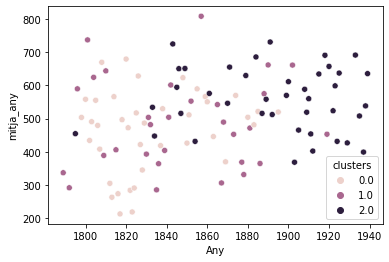

In [68]:
sns.scatterplot(data=df_ml, x='Any', y='mitja_any',hue='clusters')